In [2]:
%matplotlib inline

In [3]:
import tqdm
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import optim
from torch.nn import init
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import functional as FT

In [5]:
train = CIFAR10(
    'data', 
    transform=transforms.Compose([
        transforms.ToTensor(),
    ]), 
    download=True
)
train_dl = DataLoader(train, 32, shuffle=True, num_workers=4, drop_last=True)

Files already downloaded and verified


In [6]:
LATENT_SPACE_DIM = 24

In [7]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(16)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64)
        )
            
        
        self.fc1 = nn.Linear(8 * 8 * 64, 128)
        self.fc_bn1 = nn.BatchNorm1d(128)
        
        self.fc2 = nn.Linear(128, LATENT_SPACE_DIM)
        self.fc_bn2 = nn.BatchNorm1d(LATENT_SPACE_DIM)
    
    def forward(self, x):        
        x = self.conv1(x)
        x = self.conv2(x)

        x = x.view(-1, 8 * 8 * 64)

        x = F.relu(self.fc_bn1(self.fc1(x)))
        x = F.relu(self.fc_bn2(self.fc2(x)))
        return x

In [8]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(LATENT_SPACE_DIM, 128)
        self.fc_bn1 = nn.BatchNorm1d(128)

        self.fc2 = nn.Linear(128, 64 * 8 * 8)
        self.fc_bn2 = nn.BatchNorm1d(64 * 8 * 8)

        self.conv1 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )
        self.conv2 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(3)
        )
    
    def forward(self, z):
        x = F.relu(self.fc_bn1(self.fc1(z)))
        x = F.relu(self.fc_bn2(self.fc2(x))).view(-1, 64, 8, 8)
        
        x = self.conv1(x)
        x = self.conv2(x)
        
        return F.sigmoid(x)

In [9]:
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.enc_mu = nn.Linear(LATENT_SPACE_DIM, LATENT_SPACE_DIM)
        self.enc_logvar = nn.Linear(LATENT_SPACE_DIM, LATENT_SPACE_DIM)

    def forward(self, x):
        h = self.encoder(x)
        
        mu, logvar = self.enc_mu(h), self.enc_logvar(h)
        sigma = (logvar * 0.5).exp_()
        z = mu + sigma * torch.randn_like(sigma)
        
        xh = self.decoder(z)
        
        return (mu, sigma), xh
    
    def sample(self, n=1):
        z = torch.randn(n, LATENT_SPACE_DIM, 
                        dtype=torch.float)
        
        xh = self.decoder(z)
        xh = xh.detach()
        
        return xh

In [10]:
def latent_loss(mu, logvar):
    return -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

In [11]:
model = VAE(Encoder(), Decoder())
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [34]:
model.train()

for epoch in tqdm.tqdm_notebook(range(15, 25)):
    total_loss = 0
    for x, _ in tqdm.tqdm_notebook(train_dl):
        x = x
        h, xh = model(x)
        loss = F.binary_cross_entropy(xh, x) + latent_loss(*h)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    total_loss /= len(train_dl)
    print(f'i_epoch={epoch} loss={total_loss}')

i_epoch=15 loss=0.5906225647037985


i_epoch=16 loss=0.5902186213550128


i_epoch=17 loss=0.5898850643375314


i_epoch=18 loss=0.5895578391497022


i_epoch=19 loss=0.5892027176143876


i_epoch=20 loss=0.5885226887563737


i_epoch=21 loss=0.5881643592166534


i_epoch=22 loss=0.5879367792575826


i_epoch=23 loss=0.5877963581173734


i_epoch=24 loss=0.5875886153625313



In [35]:
model.eval();

In [36]:
def t2np(image):
    image = np.array(image.getdata(), np.uint8).reshape(image.size[1], image.size[0], 3)
    return image

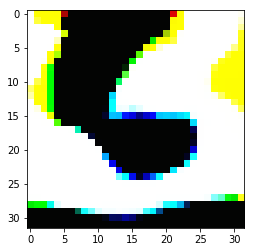

In [50]:

image = FT.to_pil_image(model.sample()[0])
image = t2np(image)
plt.imshow(image);

In [51]:
model.sample()[0]

tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.8291, 0.0151, 0.0151,  ..., 1.0000, 1.0000, 1.0000],
         [0.9927, 0.0151, 0.0151,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 0.9995,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.9626, 0.0163, 0.0163,  ..., 1.0000, 1.0000, 1.0000],
         [0.9997, 0.0163, 0.0163,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.

In [38]:
def plot_images(images,
                images_prime,
                figsize = (8, 24)):
    plt.figure(figsize=figsize)

    for i in range(10):
        plt.subplot(10, 2, 2 * i + 1)
        plt.imshow(images[i], vmin=0, vmax=1)
        plt.title('Test input')
        plt.colorbar()

        plt.subplot(10, 2, 2 * i + 2)
        plt.imshow(images_prime[i], vmin=0, vmax=1)
        plt.title('Reconstruction')
        plt.colorbar()

    plt.plot()

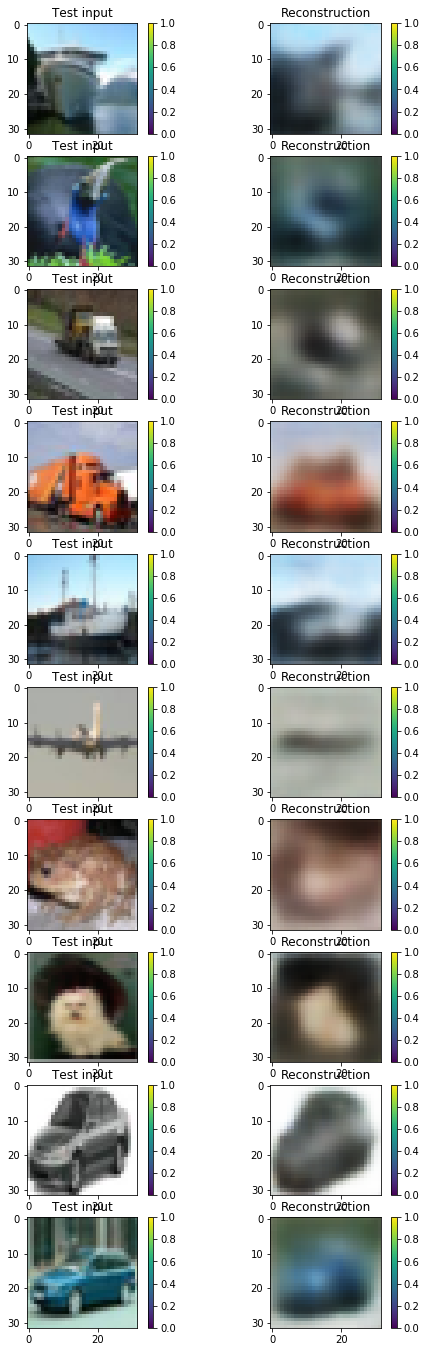

In [53]:
img = next(iter(train_dl))[0]
res = model(img)[1]
plot_images([FT.to_pil_image(img[i]) for i in range(len(img))], [FT.to_pil_image(res[i]) for i in range(len(img))])